<!-- <center> -->
<h1> Using MOMENT for Anomaly Detection </h1>
<!-- </center> -->
<hr>

## Contents
### 1. A Quick Introduction to Anomaly Detection
### 2. Loading MOMENT
### 3. Inputs and Outputs
### 4. Zero-Shot Anomaly Detection
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Anomaly Detection using MOMENT
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Results
### 5. 5. Example Code to Fine-tune MOMENT for Anomaly Detection

## 1. A Quick Introduction to Anomaly Detection

Detecting anomalous subsequences within time series data is important across various domains, spanning from manufacturing processes to financial applications and healthcare monitoring. An anomaly within a time series can indicate crucial events such as production faults, delivery bottlenecks, system defects, or irregular heart rhythms, making anomaly detection a focal point of interest. Given the large size and often intricate patterns exhibited by time series data, there is substantial interest in developing machine learning models to automatically identify anomalies. In this tutorial, we will explore how we can use MOMENT to detect anomalies in a zero-shot setting! Below, we mathematically describe the anomaly detection problem:

**Problem**: Given a time-series $T = [x_1, ..., x_L], \ x_i \in \mathbb{R}^{C}$ of length $L$ with $C$ channels (sensors or variables) and a anolmaly criterion $C$, the Anomaly-Detection problem is to predict the anomaly score at each timestamp of the time-series $C = [C_1, ..., C_L]$. 

In this tutorial, we will use MOMENT to reconstruct an input time series. Since MOMENT is pre-trained on millions of timesteps of time series data, we expect it to model "normal behavior". Therefore, we will consider timesteps where the observed values and MOMENT's predictions are signficantly different to be anomalies.

## 2. Loading MOMENT

We will first install the MOMENT package, load some essential packages and the pre-trained model. 

MOMENT can be loaded in 4 modes: (1) `reconstruction`, (2) `embedding`, (3) `forecasting`, and (4) `classification`.

In the `reconstruction` mode, MOMENT reconstructs input time series, potentially containing missing values. We can solve imputation and anomaly detection problems in this mode. This mode is suitable for solving imputation and anomaly detection tasks. During pre-training, MOMENT is trained to predict the missing values within uniformly randomly masked patches (disjoint sub-sequences) of the input time series, leveraging information from observed data in other patches. As a result, MOMENT comes equipped with a pre-trained reconstruction head, enabling it to address imputation and anomaly detection challenges in a zero-shot manner! Check out the `imputation.ipynb` notebook for more details!

In the `embedding` model, MOMENT learns a $d$-dimensional embedding (e.g., $d=1024$ for `MOMENT-1-large`) for each input time series. These embeddings can be used for clustering and classification. MOMENT can learn embeddings in a zero-shot setting! Check out `representation_learning.ipynb` notebook for more details! 

The `forecasting` and `classification` modes are used for forecasting and classification tasks, respectively. In these modes, MOMENT learns representations which are subsequently mapped to the forecast horizon or the number of classes, using linear forecasting and classification heads. Both the forecasting and classification head are randomly initialized, and therefore must be fine-tuned before use. Check out the `forecasting.ipynb` notebook for more details!

In [1]:
!pip install numpy pandas scikit-learn matplotlib tqdm
!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /tmp/pip-req-build-zguwwpiz
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /tmp/pip-req-build-zguwwpiz
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit 284d7ff16a817cbdb1337ffc7f7fa5146453a50c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import sys
import os

# Add your project root to sys.path (adjust the path below)
project_root = '/work/pi_shenoy_umass_edu/hshastri/FMaaS-motivation/timeseries/moment-main'  # the folder containing 'momentfm'
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(f"{project_root}/tutorials")

In [3]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={"task_name": "reconstruction"},  # For anomaly detection, we will load MOMENT in `reconstruction` mode
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

## 3. Inputs and Outputs

Let's begin by performing a forward pass through MOMENT and examining its outputs!

MOMENT takes 3 inputs: 
1. An input time series of length $T=512$ timesteps and $C$ channels, and 
2. Two optional masks, both of length $T=512$. 
    - The input mask is utilized to regulate the time steps or patches that the model should attend to. For instance, in the case of shorter time series, you may opt not to attend to padding. To implement this, you can provide an input mask with zeros in the padded locations.  
    - The second mask, referred to simply as mask, denotes masked or unobserved values. We employ mask tokens to replace all patches containing any masked time step (for further details, refer to Section 3.2 in our [paper](https://arxiv.org/abs/2402.03885)). MOMENT can attend to these mask tokens during reconstruction.
    - By default, all time steps are observed and attended to.

MOMENT returns a `TimeseriesOutputs` object. Since this is an anomaly detection task (via reconstruction), it returns a `reconstruction` of the input. 


In [5]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512)
output = model(x_enc=x)
pprint(output)

/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=None,
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]),
                  reconstruction=tensor([[[-0.2384, -0.0981, -0.2374,  ...,  0.3836, -0.2003,  0.0761]],

        [[-0.1014, -0.2201, -0.2002,  ...,  0.1210,  0.0617,  0.1314]],

        [[-0.1420, -0.1911, -0.0848,  ..., -0.0696,  0.1755, -0.0917]],

        ...,

        [[-0.5229,  0.0838, -0.2380,  ...,  0.1110, -0.3496,  0.3

## 4. Zero-Shot Anomaly Detection

Now we'll show you how to use MOMENT to do zero-shot anomaly detection!

In these experiments, we will use the tiltAPB2 dataset from the [UCR Anomaly Archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/). The waveform is the Arterial blood pressure (ABP) of a healthy male on a tilt table. [Wu et al., 2021](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9537291) introduced a synthetic anomaly such that the direction of the time series is reversed for about 4 beats.

We'll start by reading and pre-processing this dataset using the `AnomalyDetectionDataset` class. Since we can do zero-shot anomaly detection, we will just load the testing part of this data. Note that MOMENT was not exposed to the testing part of this dataset during pre-training. 

In [6]:
from momentfm.data.anomaly_detection_dataset import AnomalyDetectionDataset

test_dataset = AnomalyDetectionDataset(data_split='test', random_seed=13)

Now let's visualize the time series

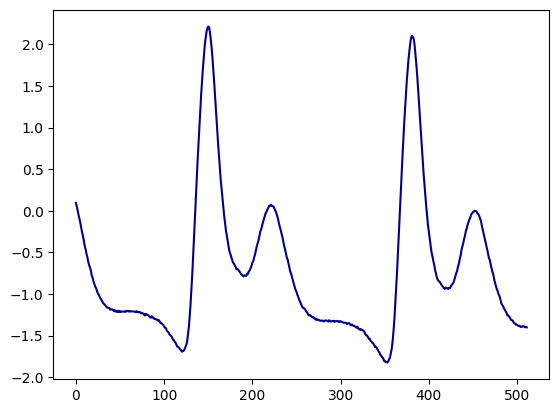

In [7]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_dataset))
plt.plot(test_dataset[idx][0].squeeze(), c='darkblue')
plt.show()

### 4.1 Anomaly Detection using MOMENT
Now we will use MOMENT to compute anomaly scores for the time series. 

In [8]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [14]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(x_enc=batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]
        m=output.reconstruction
        print(m.shape, batch_x.shape, batch_masks.shape)
        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

  0%|                                                                                                                                                                                       | 0/3 [00:00<?, ?it/s]/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/hshastri_umass_edu/.conda/envs/moment/lib/python3.10/site-packages/torch/utils/checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
 33%|██████████████████████████████████████████████████████████▎                    

torch.Size([64, 1, 512]) torch.Size([64, 1, 512]) torch.Size([64, 512])
torch.Size([64, 1, 512]) torch.Size([64, 1, 512]) torch.Size([64, 512])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.60it/s]

torch.Size([26, 1, 512]) torch.Size([26, 1, 512]) torch.Size([26, 512])


### 4.2 Results

We will use adjusted best F1, a metric which is frequently used in practice [Goswami et al., 2023](https://arxiv.org/abs/2210.01078), to evaluate the anomaly detection performance. MOMENT uses the mean squarred error between its predictions and the observed time series as an anomaly score. To convert anomaly score to binary predictions, we must find a threshold, such that time steps with an anomaly score exceeding this threshold are considered anomalous. Adjusted best F1 finds the best threshold which maximizes the F1 of the anomaly detection model. To account for the temporal nature of this problem, a model is said to have correctly identified the complete anomaly sequence as long as it detects any anomalous timestep.  

In [10]:
import numpy as np

trues = np.concatenate(trues, axis=0).flatten()
preds = np.concatenate(preds, axis=0).flatten()
labels = np.concatenate(labels, axis=0).flatten()

# The last and the second to last windows have overlapping timesteps. We will remove these overlapping predictions
n_unique_timesteps = 512 - trues.shape[0] + test_dataset.length_timeseries
trues = np.concatenate([trues[:512*(test_dataset.length_timeseries//512)], trues[-n_unique_timesteps:]])
preds = np.concatenate([preds[:512*(test_dataset.length_timeseries//512)], preds[-n_unique_timesteps:]])
labels = np.concatenate([labels[:512*(test_dataset.length_timeseries//512)], labels[-n_unique_timesteps:]])
assert trues.shape[0] == test_dataset.length_timeseries

# We will use the Mean Squared Error (MSE) between the observed values and MOMENT's predictions as the anomaly score
anomaly_scores = (trues - preds)**2

In [11]:
from momentfm.utils.anomaly_detection_metrics import adjbestf1

print(f"Zero-shot Adjusted Best F1 Score: {adjbestf1(y_true=labels, y_scores=anomaly_scores)}") 

Zero-shot Adjusted Best F1 Score: 0.9993900272573951


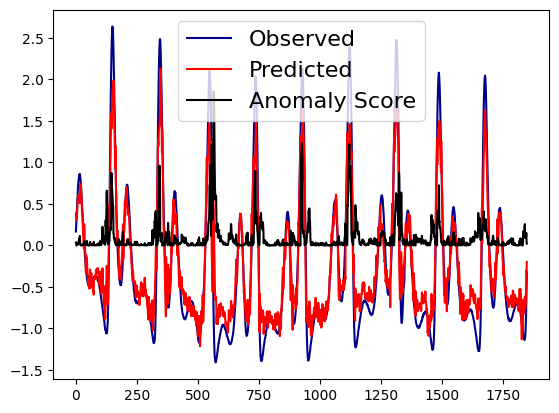

In [12]:
anomaly_start = 74158
anomaly_end = 74984
start = anomaly_start-512
end = anomaly_end+512

plt.plot(trues[start:end], label="Observed", c='darkblue')
plt.plot(preds[start:end], label="Predicted", c='red')
plt.plot(anomaly_scores[start:end], label="Anomaly Score", c='black')
plt.legend(fontsize=16)
plt.show()

## 5. Example Code to Fine-tune MOMENT for Anomaly Detection

To improve MOMENT's anomaly performance, you can fine-tune it on any dataset. In our [paper](https://arxiv.org/abs/2402.03885), we fine-tune the final reconstruction head, but you can also fine-tune the entire model on your data. Here is some example code:

```python

# Optimize Mean Squarred Error using your favourite optimizer
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

mask_generator = Masking(mask_ratio=0.3) # Mask 30% of patches randomly 

for batch_x, batch_masks in tqdm(test_dataloader, total=len(test_dataloader)):
    n_channels = batch_x.shape[1]
    
    # Reshape to [batch_size * n_channels, 1, window_size]
    batch_x = batch_x.reshape((-1, 1, 512)) 
    
    batch_masks = batch_masks.to(device).long()
    batch_masks = batch_masks.repeat_interleave(n_channels, axis=0)
    
    # Randomly mask some patches of data
    mask = mask_generator.generate_mask(
        x=batch_x, input_mask=batch_masks).to(device).long()

    # Forward
    output = model(x_enc=batch_x, input_mask=batch_masks, mask=mask) 
    
    # Compute loss
    loss = criterion(output.reconstruction, batch_x)
        
    print(f"loss: {loss.item()}")
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

In [ ]:
print()

As we can see from the figure, the anomaly score is higher around the anomaly.